In [1]:
# HL23PYR Stage 1: Healthy Neuron Simulation and Validation

# ✅ Goal: Simulate the healthy HL23PYR neuron using NetPyNE/NEURON,
# run current injection protocol (170–310 pA), extract features with EFEL,
# and compare to AllenDB human data (Cell ID: 531526539).

In [2]:
# --- Imports and Setup ---
from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import efel
import os
import json
import sys

savedata = 1 # Save Netpyne and BBP soma_voltage

%matplotlib inline

--No graphics will be displayed.


In [3]:
!nrnivmodl mod/

/opt/miniconda3/envs/netpyne/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/tarek/Desktop/NEW-HL23PYR_AD
Mod files: "mod/mod//CaDynamics.mod" "mod/mod//Ca_HVA.mod" "mod/mod//Ca_LVA.mod" "mod/mod//Gfluct.mod" "mod/mod//Ih.mod" "mod/mod//Im.mod" "mod/mod//K_P.mod" "mod/mod//K_T.mod" "mod/mod//Kv3_1.mod" "mod/mod//NMDA.mod" "mod/mod//NaTg.mod" "mod/mod//Nap.mod" "mod/mod//ProbAMPANMDA.mod" "mod/mod//ProbUDFsyn.mod" "mod/mod//SK.mod" "mod/mod//epsp.mod" "mod/mod//tonic.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created x86_64/special


In [4]:
from netpyne import sim, specs
import pickle

cfg = specs.SimConfig()     

cfg.duration = 2350 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'cell': 4321, 'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -80}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

allpops = ['HL23PYR_' + str(i) for i in range(1, 16)]

cfg.recordCells = allpops  # which cells to record from

cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'},
                    # 'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},                  
                    # 'V_dend_5': {'sec':'dend_5', 'loc':0.5, 'var':'v'},
                    }


## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.025      

cfg.simLabel = 'HL23PYR_stage1'
cfg.saveFolder = '.'
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData' , 'simConfig', 'netParams', 'netParams']
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			##  
cfg.saveCellConns = True		##  

cfg.analysis['plotTraces'] = {'include': allpops, 'figSize': (12, 6), 'timeRange': [1000,cfg.duration], 'saveFig': False, 'overlay': True, 'oneFigPer': 'trace'}  # Plot recorded traces for this list of cells


In [5]:
#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

netParams = specs.NetParams()   # object of class NetParams to store the network parameters

cellModels = ['HH_full']
Epops = ['HL23PYR']

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------

cellName = 'HL23PYR'
cellRule = netParams.importCellParams(label=cellName, somaAtOrigin=True,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper.py',
        cellName='loadCell_' + cellName,
        cellInstance = True,
        cellArgs={'cellName': cellName})


NeuronTemplate_HL23PYR[0]


In [6]:
# # --- Define SimConfig ---
# simConfig = specs.SimConfig()
# simConfig.duration = 500  # ms
# simConfig.dt = 0.025
# simConfig.verbose = False
# simConfig.recordTraces = {'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}}
# simConfig.recordStep = 0.1
# simConfig.filename = 'HL23PYR_stage1'

In [7]:
#------------------------------------------------------------------------------
# Define HL23PYR Populations — One Per Step Current Level
#------------------------------------------------------------------------------

cellName = 'HL23PYR'
for popName in allpops:
    netParams.popParams[popName] = {
        'cellType': cellName,
        'cellModel': 'HH_full',
        'numCells': 1
    }

#------------------------------------------------------------------------------
# Define Step Current Parameters for IClamp
#------------------------------------------------------------------------------

cfg.IClamp = []

num_cells = len(allpops)
current_start = -0.3  # Initial current in nA
current_end = 0.4     # Final current in nA
current_step = 0.05   # Step size in nA

cfg.IClampnumber = 0

for i, popName in enumerate(allpops):
    current_amp = current_start + i * current_step
    cfg.IClamp.append({
        'pop': popName,
        'sec': 'soma_0',
        'loc': 0.5,
        'start': 1200,  # ms
        'dur': 800,     # ms
        'amp': current_amp
    })
    cfg.IClampnumber += 1

#------------------------------------------------------------------------------
# Generate IClamp Stimulus and Target Connections
#------------------------------------------------------------------------------

for j in range(cfg.IClampnumber):
    key = 'IClamp' + str(j+1)
    params = cfg.IClamp[j]
    pop, sec, loc, start, dur, amp = [params[s] for s in ['pop', 'sec', 'loc', 'start', 'dur', 'amp']]

    # Define the stimulation source
    netParams.stimSourceParams[key] = {
        'type': 'IClamp',
        'delay': start,
        'dur': dur,
        'amp': amp
    }

    # Connect the stim to the target population
    netParams.stimTargetParams[f"{key}_{pop}"] = {
        'source': key,
        'conds': {'pop': pop},
        'sec': sec,
        'loc': loc
    }


In [24]:
for secName, sec in cellRule['secs'].items():
    mechs = sec.get('mechs', {})
    if 'NaTg' in mechs:
        print(f"{secName} NaTg gbar: {mechs['NaTg']['gbar']}")
    if 'Ih' in mechs:
        print(f"{secName} Ih gbar: {mechs['Ih']['gbar']}")
    if 'Kv3_1' in mechs:
        print(f"{secName} Kv3_1 gbar: {mechs['Kv3_1']['gbar']}")
    if 'SK' in mechs:
        print(f"{secName} SK gbar: {mechs['SK']['gbar']}")

soma_0 NaTg gbar: 0.272
soma_0 Ih gbar: 0.000148
soma_0 Kv3_1 gbar: 0.0424
soma_0 SK gbar: 0.000853
dend_0 Ih gbar: 7.09e-07
dend_1 Ih gbar: 7.09e-07
dend_2 Ih gbar: 7.09e-07
dend_3 Ih gbar: 7.09e-07
dend_4 Ih gbar: 7.09e-07
dend_5 Ih gbar: 7.09e-07
dend_6 Ih gbar: 7.09e-07
dend_7 Ih gbar: 7.09e-07
dend_8 Ih gbar: 7.09e-07
dend_9 Ih gbar: 7.09e-07
dend_10 Ih gbar: 7.09e-07
dend_11 Ih gbar: 7.09e-07
dend_12 Ih gbar: 7.09e-07
dend_13 Ih gbar: 7.09e-07
dend_14 Ih gbar: 7.09e-07
dend_15 Ih gbar: 7.09e-07
dend_16 Ih gbar: 7.09e-07
dend_17 Ih gbar: 7.09e-07
dend_18 Ih gbar: 7.09e-07
dend_19 Ih gbar: 7.09e-07
dend_20 Ih gbar: 7.09e-07
dend_21 Ih gbar: 7.09e-07
dend_22 Ih gbar: 7.09e-07
dend_23 Ih gbar: 7.09e-07
dend_24 Ih gbar: 7.09e-07
dend_25 Ih gbar: 7.09e-07
dend_26 Ih gbar: 7.09e-07
dend_27 Ih gbar: 7.09e-07
dend_28 Ih gbar: 7.09e-07
dend_29 Ih gbar: 7.09e-07
apic_0 Ih gbar: 0.0002252837
apic_1 Ih gbar: 0.0002326263
apic_2 Ih gbar: [0.000252348, 0.0002950795, 0.000342603, 0.0003954558, 0

In [8]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.defineCellShapes()  # in case some cells had stylized morphologies without 3d pts
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.net.defineCellShapes()


Start time:  2025-07-17 12:16:43.000437

Creating network of 15 cell populations on 1 hosts...
  Number of cells on node 0: 15 
  Done; cell creation time = 0.33 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 15 
  Done; cell stims creation time = 0.00 s.
Recording 30 traces of 2 types on node 0


In [9]:
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc
sim.analysis.plotShape()  

%matplotlib inline

0.0s

Running simulation using NEURON for 2350.0 ms...
0.5s
1.0s
1.5s
2.0s
  Done; run time = 40.32 s; real-time ratio: 0.06.

Gathering data...
  Done; gather time = 0.27 s.

Analyzing...
  Cells: 15
  Connections: 0 (0.00 per cell)
  Spikes: 102 (2.89 Hz)
  Simulated time: 2.4 s; 1 workers
  Run time: 40.32 s
   HL23PYR_1 : 0.000 Hz
   HL23PYR_2 : 0.000 Hz
   HL23PYR_3 : 0.000 Hz
   HL23PYR_4 : 0.000 Hz
   HL23PYR_5 : 0.000 Hz
   HL23PYR_6 : 0.000 Hz
   HL23PYR_7 : 0.000 Hz
   HL23PYR_8 : 0.000 Hz
   HL23PYR_9 : 3.830 Hz
   HL23PYR_10 : 4.681 Hz
   HL23PYR_11 : 5.532 Hz
   HL23PYR_12 : 6.383 Hz
   HL23PYR_13 : 6.809 Hz
   HL23PYR_14 : 7.660 Hz
   HL23PYR_15 : 8.511 Hz
Plotting recorded cell traces ... trace
  Done; plotting time = 0.43 s

Total time = 41.39 s
Plotting 3D cell shape ...


In [10]:
# Extract firing rate
spk_times = sim.simData['spkt']  # Spike Times
spk_ids = sim.simData['spkid']  # Spike IDs

steps, rates = np.unique(spk_ids, return_counts=True)

In [11]:
# responses = []

# # --- Plot Voltage Responses ---
# plt.figure(figsize=(10, 6))
# for r in responses:
#     plt.plot(r['t'], r['V'], label=f"{r['amp']} pA")
# plt.xlabel('Time (ms)')
# plt.ylabel('Vm (mV)')
# plt.title('HL23PYR Voltage Responses to Step Currents')
# plt.legend()
# plt.show()

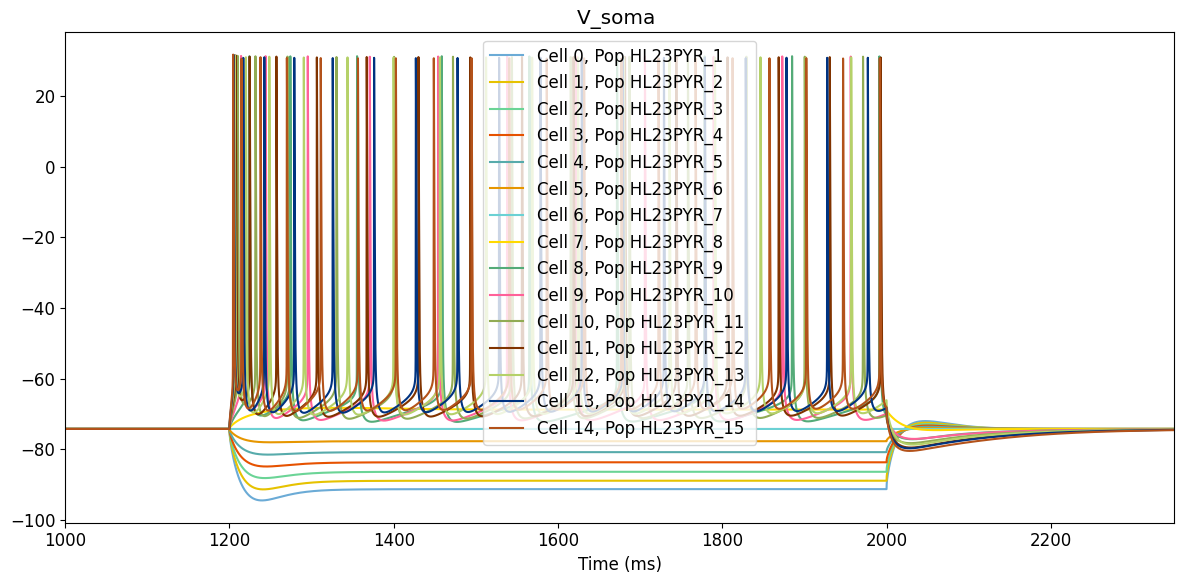

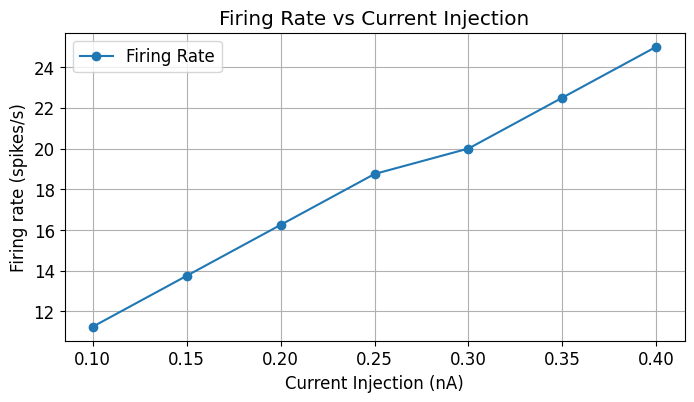

In [12]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(current_start + steps * current_step, rates/0.8, marker='o', label='Firing Rate')
plt.xlabel('Current Injection (nA)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('Firing Rate vs Current Injection')
plt.grid(True)
plt.legend()
plt.show()


Text(0.5, 0, 'Current Injection (nA)')

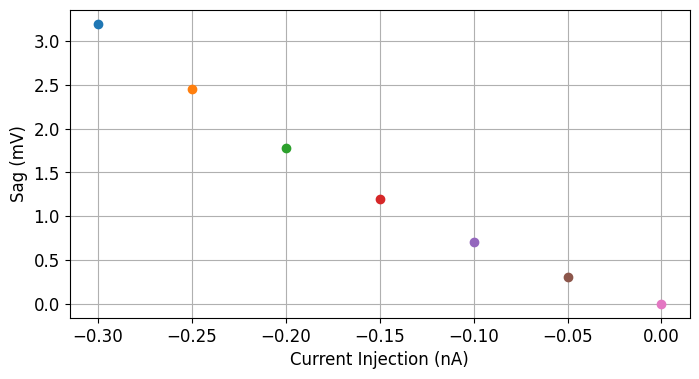

In [13]:
plt.figure(figsize=(8, 4))
plt.grid(True)

for steps,cellName in enumerate(list(sim.simData['V_soma'].keys())[:7]):
    if 'cell' in cellName:
        plt.plot(current_start + steps * current_step,list(sim.simData['V_soma'][cellName])[80000]-np.min(list(sim.simData['V_soma'][cellName])[40000:80000]), 'o')

plt.ylabel('Sag (mV)')
plt.xlabel('Current Injection (nA)')


In [14]:
import numpy as np

# Extract spike times and IDs
spike_times = np.array(sim.simData['spkt'])  # Spike times
spike_ids = np.array(sim.simData['spkid'])  # Corresponding cell IDs

# Define current steps 
current_steps = np.arange(-300, 400, 50)  # pA

# Identify the first current step that reliably produces a spike
for i, current in enumerate(current_steps):
    spikes_at_current = np.any(spike_ids == i)  # Check if any cell spikes at this current
    if spikes_at_current:
        rheobase = current
        break

print(f"Rheobase: {rheobase} pA")


Rheobase: 100 pA


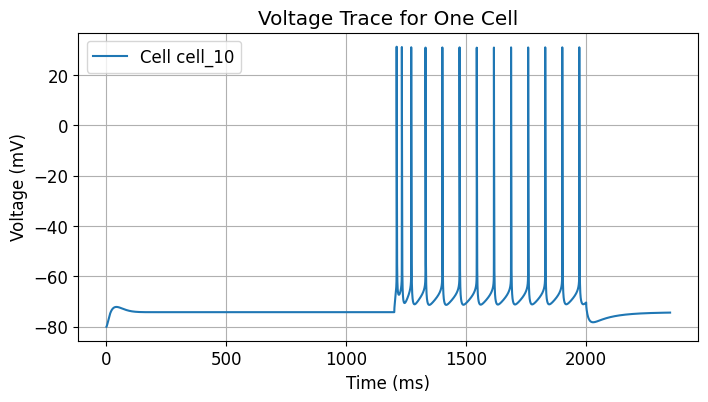

In [15]:
plt.figure(figsize=(8, 4))
cellName = list(sim.simData['V_soma'].keys())[10]  # Select the first cell
plt.plot(sim.simData['t'], sim.simData['V_soma'][cellName], label=f"Cell {cellName}")
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage Trace for One Cell')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
responses = []
step_amps = np.arange(170, 311, 20)  # pA

for amp in step_amps:
    cfg = specs.SimConfig()
    cfg.duration = 2000
    cfg.dt = 0.025
    cfg.verbose = False
    cfg.recordTraces = {'V_soma': {'sec': 'soma_0', 'loc': 0.5, 'var': 'v'}}
    cfg.recordStep = 0.1

    cfg.stimSourceParams = {
        'Input': {'type': 'IClamp', 'delay': 100, 'dur': 300, 'amp': amp / 1000}
    }
    cfg.stimTargetParams = {
        'Input->HL23PYR': {'source': 'Input', 'sec': 'soma_0', 'loc': 0.5, 'conds': {'pop': 'HL23PYR'}}
    }

    sim.createSimulate(netParams=netParams, simConfig=cfg, output=False)

    t = np.array(sim.simData['t'])
    V = np.array(sim.simData['V_soma'][0])
    responses.append({'amp': amp, 't': t, 'V': V})



Start time:  2025-07-17 12:17:30.941400

Creating network of 15 cell populations on 1 hosts...
  Number of cells on node 0: 15 
  Done; cell creation time = 0.34 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 15 
  Done; cell stims creation time = 0.01 s.
Recording 0 traces of 0 types on node 0

Running simulation using NEURON for 2000.0 ms...
  Done; run time = 40.50 s; real-time ratio: 0.05.

Gathering data...
  Done; gather time = 0.29 s.

Analyzing...
  Cells: 15
  Connections: 0 (0.00 per cell)
  Spikes: 123 (4.10 Hz)
  Simulated time: 2.0 s; 1 workers
  Run time: 40.50 s

Start time:  2025-07-17 12:18:12.109665

Creating network of 15 cell populations on 1 hosts...
  Number of cells on node 0: 15 
  Done; cell creation time = 0.32 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 15 
 

In [20]:
import efel

# Define EFEL features to extract
feature_names = [
    'peak_voltage', 'AP_amplitude', 'AP_width',
    'adaptation_index', 'sag_ratio2', 'voltage_base',
    'mean_frequency', 'time_to_first_spike'
]

# Prepare input for EFEL
efel_features = []
for r in responses:
    ef_dict = {
        'stim_start': [1200],        # ms
        'stim_end': [2000],          # ms
        'T': r['t'].tolist(),                # time trace
        'V': r['V'].tolist(),                # voltage trace
        'stimulus_current': [r['amp'] / 1000]  # nA
    }
    efel_features.append(ef_dict)

# Run EFEL
results = efel.getMeanFeatureValues(efel_features, feature_names)


In [17]:
# --- Prepare EFEL Input for Feature Extraction ---
responses = []

ef_features = []
for r in responses:
    ef_dict = {
        'stim_start': [1200],
        'stim_end': [2000],
        'T': r['t'],
        'V': r['V'],
        'stimulus_current': [r['amp'] / 1000],
    }
    ef_features.append(ef_dict)

In [18]:
print(f"Number of sweeps in responses: {len(responses)}")
if len(responses) > 0:
    print(f"Example sweep keys: {responses[0].keys()}")
    print(f"Example voltage length: {len(responses[0]['V'])}")


Number of sweeps in responses: 0


Text(0.5, 0, 'Current Injection (nA)')

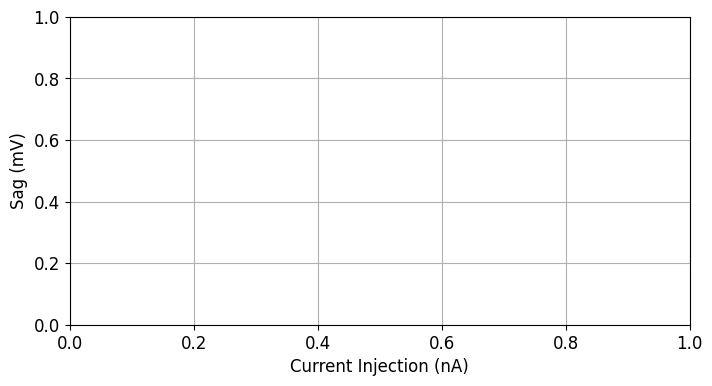

In [19]:
plt.figure(figsize=(8, 4))
plt.grid(True)

for steps,cellName in enumerate(list(sim.simData['V_soma'].keys())[:7]):
    if 'cell' in cellName:
        plt.plot(current_start + steps * current_step,list(sim.simData['V_soma'][cellName])[80000]-np.min(list(sim.simData['V_soma'][cellName])[40000:80000]), 'o')

plt.ylabel('Sag (mV)')
plt.xlabel('Current Injection (nA)')


In [21]:
# Check structure of results
for i, r in enumerate(results):
    print(f"Sweep {responses[i]['amp']} pA -> Features extracted:")
    print(r)


In [25]:
import pandas as pd

# Build DataFrame from EFEL results
amps = [r['amp'] for r in responses]
efel_df = pd.DataFrame(results, index=[f"{amp} pA" for amp in amps])

# Select only available features
available_features = [f for f in feature_names if f in efel_df.columns]
efel_df = efel_df[available_features]

# Display
print("✅ Extracted EFEL Features:")
print(efel_df)


✅ Extracted EFEL Features:
Empty DataFrame
Columns: []
Index: []


In [ ]:
# --- Print Extracted Features ---
step_amps = current_start + steps * current_step  # Calculate step amplitudes
for i, r in enumerate(results):
    print(f"\nSweep {step_amps[i]} pA:")
    for feat, val in r.items():
        print(f"  {feat}: {val}")
# --- Save Simulation Data ---
if savedata:
    sim.saveData()  # Save simulation data
    with open('HL23PYR_stage1_data.pkl', 'wb') as f:
        pickle.dump(sim.simData, f)

    # Save EFEL features to a JSON file
    with open('HL23PYR_stage1_features.json', 'w') as f:
        json.dump(results, f, indent=4)